In [1]:
from sklearn.preprocessing import StandardScaler
from visualization_fct import *
# from bokeh.plotting import output_file, show, save

from sklearn.mixture import GaussianMixture
from bokeh.plotting import output_notebook, show

import matplotlib.pyplot as plt  # , mpld3
%matplotlib notebook
output_notebook()

data = pd.read_csv("../asm_data/asm_data_for_ml.txt", sep='\t')
del data['MJD']
# del data['error']
# del data['errorA']
# del data['errorB']
# del data['errorC']
data['rateCA'] = data.rateC / data.rateA
data_thr = mask(data, 'orbit')  # rm too large values except for 'orbit'

# w useless here since sklearn.gaussian_mixture does not support weighted samples
w = np.concatenate([np.array(data_thr[name]).reshape(-1, 1)
                    for name in ['error', 'errorA', 'errorB', 'errorC']],
                   axis=1)
# XXX add the error for the ratio?
w = np.concatenate([w,
                    (data_thr['errorC'] / data_thr['rateA']).reshape(-1, 1)],
                   axis=1)

del data_thr['error']
del data_thr['errorA']
del data_thr['errorB']
del data_thr['errorC']


np.random.seed(0)

X = np.c_[data_thr.orbit, data_thr.rate, data_thr.rateA, data_thr.rateB,
          data_thr.rateC, data_thr.rateCA]

scaler = StandardScaler()
X = scaler.fit_transform(X)
# 1 corresponds to data_thr.rate and 4=5-1 to data_thr.rateC
w = w / np.sqrt(scaler.var_[1:])

w = np.exp(-np.exp(3 * w.mean(axis=1)))


Loading BokehJS ...

<IPython.core.display.Javascript object>


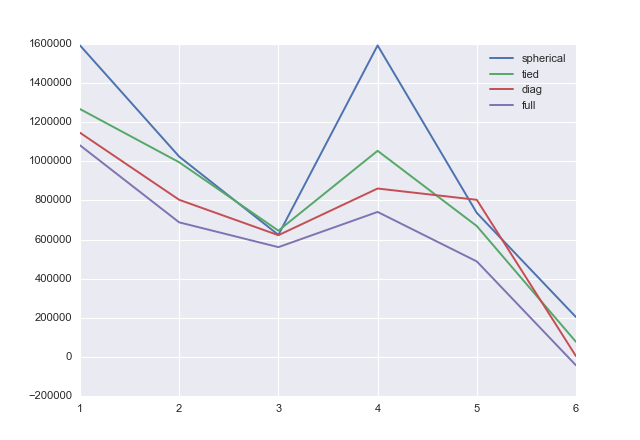

In [2]:
# gmm model selection with bic:
np.random.seed(0)

lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a mixture of Gaussians with EM
        gmm = GaussianMixture(n_components=n_components, covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))

for name, col  in zip(cv_types, np.array(bic).reshape(-1, len(cv_types)).T): 
    plt.plot(n_components_range, col, label=name)
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


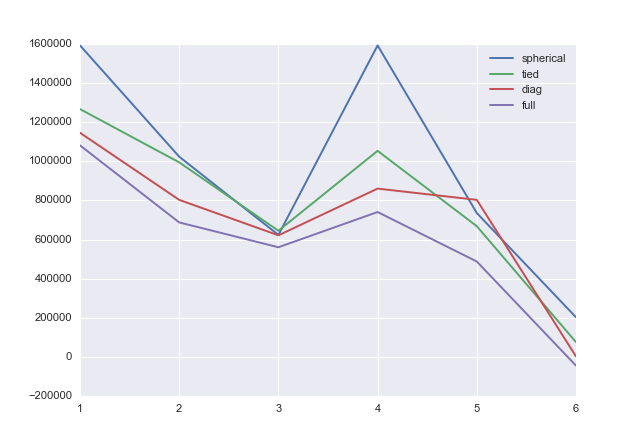

In [3]:
# gmm model selection with aic:
np.random.seed(0)

lowest_aic = np.infty
aic = []
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a mixture of Gaussians with EM
        gmm = GaussianMixture(n_components=n_components, covariance_type=cv_type)
        gmm.fit(X)
        aic.append(gmm.aic(X))

plt.figure()
for name, col  in zip(cv_types, np.array(aic).reshape(-1, len(cv_types)).T): 
    plt.plot(n_components_range, col, label=name)
plt.legend()
plt.show()

In [13]:
gmm = GaussianMixture(n_components=3, covariance_type='full', n_init=1)
gmm.fit(X)  # , weights=w) not implemented in sklearn yet
preds = gmm.predict(X)
probs = gmm.predict_proba(X)

data_thr['preds'] = pd.Series(preds).astype("category")

color_key = ["red", "blue", "yellow", "grey", "black", "purple", "pink",
             "brown", "green", "orange"]  # Spectral9
color_key = color_key[:len(set(preds))+1]

covs = gmm.covariances_
means = gmm.means_

# transform cov for non-standardizeed data:
covs = np.array([np.dot(np.diag(np.sqrt(scaler.var_)),
                        np.dot(covs[j], np.diag(np.sqrt(scaler.var_))))
                 for j in range(covs.shape[0])])
means = np.array([scaler.inverse_transform(means[j].reshape(1, -1)).T
                  for j in range(means.shape[0])])

# single plot rateCA vs rate with predicted classes and ellipses:
x = 5
y = 1
covs_xy = [covs[j][[x, y]][:, [x, y]] for j in range(len(covs))]
means_xy = [means[j][[x, y]] for j in range(len(covs))]

single_plot = bokeh_datashader_plot(data_thr, covs=covs_xy, means=means_xy,
                                    x_name='rateCA',
                                    y_name='rate',
                                    plot_width=900, plot_height=300,
                                    pixel_width=3000, pixel_height=1000,
                                    spread=True, color_key=color_key)
show(single_plot)